#### Economics 8185 - PS2 ####
##### Advanced Topics in Macroeconomics-Computation #####
###### Belmudes Lucas, belmu002@umn.edu ######
###### 10th Of October, 2022 ######
<hr />

##### Exercise 1: #####

Compute equilibria of the following growth model:
$$
\begin{array}{ll}
\max _{\left\{c_t, x_t, \ell_t\right\}} E & \sum_{t=0}^{\infty} \beta^t\left\{\log \left(c_t\right)+\psi \log \left(\ell_t\right)\right\} N_t \\
\text { subj. to } & c_t+x_t=k_t^\theta\left(\left(1+\gamma_z\right)^t z_t h_t\right)^{1-\theta} \\
& N_{t+1} k_{t+1}=\left[(1-\delta) k_t+x_t\right] N_t \\
& \log z_t=\rho \log z_{t-1}+\epsilon_t, \quad \epsilon \sim N\left(0, \sigma_\epsilon^2\right) \\
& h_t+\ell_t=1 \\
& c_t, x_t \geq 0 \quad \text { in all states }
\end{array}
$$
where $N_t=\left(1+\gamma_n\right)^t$ using the following methods:
<ul>
  <li>Iterate on Bellman's equation</li>
  <li>Map it to a linear quadratic problem and try three different versions as discussed in class, that is, with the return function depending on either
    <ul>
        <li>Consumption and leisure.</li>
        <li>Hours, capital today, and capital tomorrow; or </li>
        <li>Capital today and capital tomorrow </li>
    </ul>
  <li> Apply Vaughan's method.</li>
</ul>
<hr />

##### Method 1: Iterate on the Bellman's Equation #####

* Note that the economy grows at a rate of $(1+\gamma_n)(1+\gamma_z)^{1-\theta}$.
* We need to Detrend the variables so that we can find a steady state.
* We will use hat notation to denote percapita-technology ajusted variables.
* The value function function can be then rewritten as:

$$V(\hat{k},z)=\max_{h,\hat{k^{\prime}}} ln\left(\hat{k}^{\theta}(zh)^{(1-\theta)} - (1+\gamma_n)(1+\gamma_z)^{(1-\theta)}\hat{k^\prime} + (1-\delta)\hat{k}\right) + \psi ln(1-h) + \hat{\beta} V(\hat{k^\prime},z^{\prime})$$

st. $$ln(z^{\prime})=\rho ln(z) + \epsilon, \quad \epsilon\sim N(0,\sigma^2)$$

Step 0: Import modules.

In [2]:
import quantecon as qe
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import interpolate
warnings.filterwarnings("ignore", category=RuntimeWarning) 

Step 1: Create class.

In [3]:
from ctypes.wintypes import tagPOINT


class VFI:

    def __init__(self, ρ, n_k, n_z, n_h, lnz_bar, σ, θ, β, δ=0.3, ψ=5, γ_n=0.01, γ_z=0.02, T=250):
        self.n_k = n_k                                                                      # No. of grid points for K.                                                       
        self.n_z = n_z                                                                      # No. of grid points for Z.
        self.n_h = n_h                                                                      # No. of grid points for H.
        self.γ_n = γ_n                                                                      # Population growth rate.
        self.γ_z = γ_z                                                                      # Labor TFP growth rate.
        self.γ_hat = (1+γ_n) * (1+γ_z)**(1-θ)
        self.ρ = ρ                                                                          # Memory of AR(1).
        self.σ = σ                                                                          # Variance of idd shocks.
        self.T = T                                                                          # Simulated periods.
        self.ψ = ψ                                                                          # Leisure preference.
        self.δ = δ                                                                          # Depreciation.
        self.θ = θ                                                                          # Capital Share.
        self.β_hat = β * (1 + γ_n)                                                          # Discount Factor.
        self.p_k = np.ones([self.n_z, self.n_k])*-np.inf                                    # Policy function for capital.
        self.p_ki = np.ones([self.n_z, self.n_k])*-np.inf                                   # Index for policy function for capital.
        self.p_h = np.ones([self.n_z, self.n_k])*-np.inf                                    # Policy function for labor.
        self.p_hi = np.ones([self.n_z, self.n_k])*-np.inf                                   # Index for policy function for labor.
        self.markov = qe.markov.approximation.rouwenhorst(n_z, lnz_bar, self.σ, self.ρ)     # Aux.
        self.Π = self.markov.P                                                              # Transition Matrix.
        self.z = np.exp(self.markov.state_values)                                           # TFP values in levels.
        self.K = np.linspace(0.1, 0.5, self.n_k)                                            # Capital Grid in levels.
        self.H = np.linspace(0.01, 0.99, self.n_h)                                          # Labor Grid in levels.
        self.V_0 = np.zeros([self.n_z, self.n_k])                                           # Aux.
        self.V_1 = np.ones([self.n_z, self.n_k])                                            # Aux.

    def F_ss(self):
        Λ = (((self.γ_hat/self.β_hat) + self.δ - 1)/self.θ) ** (1/(1-self.θ))
        Θ = ((1-self.θ) * Λ**(-self.θ)) / (Λ**(1-self.θ) + (1 - self.δ - self.γ_hat))
        h_ss = (1 + (self.ψ / (Λ * Θ)))**(-1) 
        k_ss = (1 - h_ss) * (Θ/self.ψ)
        return k_ss, h_ss

    def U(self, x, y):                                                                  
        return np.log(x) + self.ψ * np.log(y)

    def error(self, V1, V2):
        return np.nanmax(np.abs(V1-V2)) 

    def update(self):                                                                       # Opertator T:V_1->V_0.
        n_z, n_k, n_h = self.n_z, self.n_k, self.n_h                                        
        H, K = self.H.reshape(n_h, 1), self.K                                                                                                                      
        Π, z = self.Π, self.z                                                               
        γ_n, γ_z = self.γ_n, self.γ_z
        θ, β, δ = self.θ, self.β_hat, self.δ
        self.V_0 = self.V_1.copy()
        for i in range(n_z):
            for j in range(n_k):
                self.V_1[i,j] = np.nanmax(self.U(K[j]**θ * (z[i] * H)**(1-θ) - (1+γ_n) * (1+γ_z)**(1-θ) * K + (1-δ) * K[j], 1-H) + β * np.matmul(Π[i,:], self.V_0))

    def converge(self, tolerance, max_iter):                                                # Iterate until convergence.
        self.iterations = 0
        while self.error(self.V_0, self.V_1) > tolerance and self.iterations < max_iter:
            self.update()
            self.iterations += 1
            if (self.iterations % 100)==0:
                print(str(self.iterations)+" Iterations completed.")
                print(" Error = " + str(self.error(self.V_0, self.V_1)))        
        if self.iterations < max_iter:
            print("Solution Found.")                                                        # Compute policy functions.
            H, K = self.H.reshape(self.n_h, 1), self.K                                                                                                                      
            Π, z = self.Π, self.z                                                               
            γ_n, γ_z = self.γ_n, self.γ_z
            θ, β, δ = self.θ, self.β_hat, self.δ
            for i in range(self.n_z):
                for j in range(self.n_k):
                    aux = self.U(K[j]**θ * (z[i] * H)**(1-θ) - (1+γ_n) * (1+γ_z)**(1-θ) * K + (1-δ) * K[j], 1-H) + β * np.matmul(Π[i,:], self.V_1)                # Given K,Z create a matrix with all the options available.
                    self.p_hi[i,j], self.p_ki[i,j] = np.unravel_index(np.nanargmax(aux), aux.shape)
                    self.p_h[i,j] = H[int(self.p_hi[i,j])]
                    self.p_k[i,j] = K[int(self.p_ki[i,j])]
        else:
            print("Error - No convergence.")

    def plot(self):                                                                # Plots.
        fig, ax = plt.subplots(2, figsize=(20, 20))
        # Value function:
        labels = [r'$z_{25}$', r'$z_{50}$', r'$z_{75}$']
        aux = [0.25, 0.50, 0.75]
        colors = ['r-' ,'g-' , 'b-']
        for i in range(3):
            ax[0].plot(self.K, self.V_1[round(self.n_z*aux[i]),:], colors[i], linewidth=2, label= labels[i], alpha=0.6)
        ax[0].set_title("Value function given Z", fontsize = 15)
        ax[0].set_xlabel(r'$\hat{k}$', fontsize = 15)
        ax[0].set_ylabel(r'$V(z,\hat{k})$',fontsize = 15)
        ax[0].legend(loc="upper right", fontsize = 15)
        # Simulation:
        p_kf = interpolate.interp2d(self.K, self.z, self.p_k, kind='cubic')           # Policy function for k_hat
        #p_hf = interpolate.interp2d(self.K, self.z, self.p_h, kind='cubic')          # Policy function for h
        for i in range(4):
            e = np.random.normal(0, self.σ, self.T)
            lnz_shocks = np.empty(self.T)
            k_series = np.empty(self.T)
            lnz_shocks[0] = 0
            k_series[0] = self.F_ss()[0]
            for t in range(self.T):
                if t>0:
                    lnz_shocks[t] = self.ρ * lnz_shocks[t-1] + e[t-1]
                    k_series[t] = p_kf(k_series[t-1], np.exp(lnz_shocks[t-1])) #* ((1+γ_n)*(1+γ_z)**(1-θ))**t
            ax[1].plot(np.linspace(1,self.T,self.T), k_series)  
        ax[1].set_xlabel("t")
        ax[1].set_ylabel(r'$\hat{K_t}$')  
        ax[1].set_title("Multiple Simulations, Same " r'$\hat{K_0}$')
        
    

In [4]:
Baby_Economy_Method_1 = VFI(ρ = 0.9, n_k = 150, n_z = 50, n_h = 100, lnz_bar = 0, σ = 0.01, θ = 0.7, β = 0.95, δ = 0.9, ψ=0.5, γ_n=0.01, γ_z=0.01, T=250)                          
Baby_Economy_Method_1.converge(10e-5, 10000)

100 Iterations completed.
 Error = 0.04801592155584444
200 Iterations completed.
 Error = 0.0007689220241502426
Solution Found.


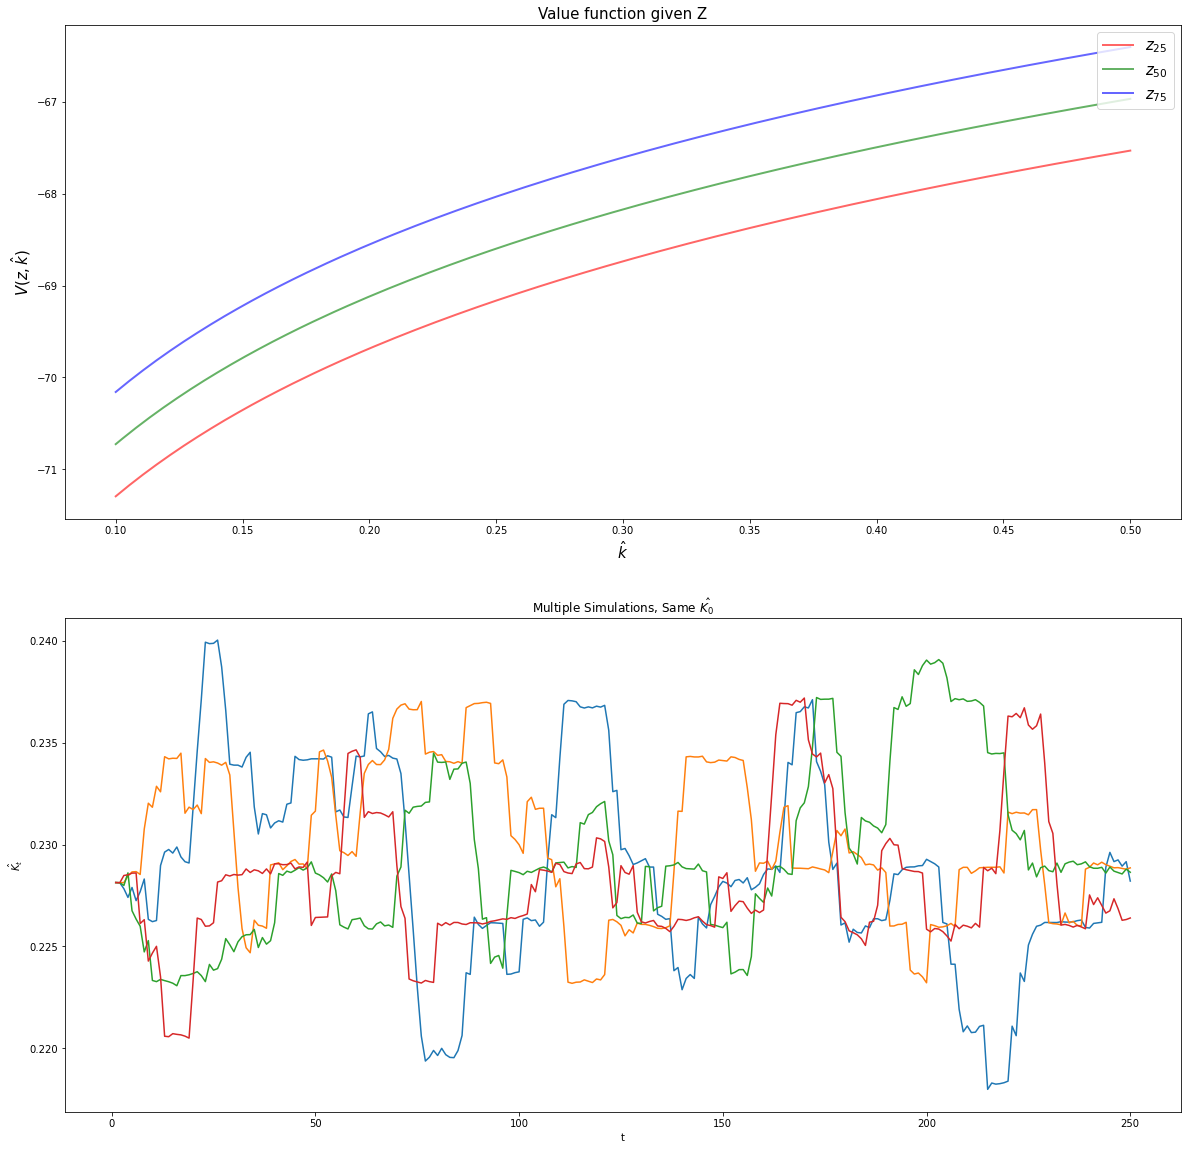

In [5]:
Baby_Economy_Method_1.plot()

<hr \>

### Exercise 2.b ### 

* Hours, capital today and capital tomorrow.

We can express the return function in terms of the capital today, the capital tomorrow and the hours worked:

$$U(ln(k_{t}), ln(k_{t+1}), h_t, ln(z_t)) = ln\left(e^{\theta ln(k_t) + (1-\theta) ln(z_t)} h_t^{1-\theta}-\gamma e^{ln{k_{t+1}}} + (1-\delta) e^{ln(k_t)}\right) + \psi ln (1 - h_t) $$

Step 2: 
Construct the Jacobian and Hessian matrices.

step 3:
Obtain the taylor approximation of the return function around the steady state values.

Matrices: 
$$u_t=\begin{bmatrix}
ln(k_{t+1})\\
h_t\\
\end{bmatrix}$$

$$x_t=\begin{bmatrix}
1\\
ln(k_t)\\
ln(z_{t})
\end{bmatrix}$$



In [202]:
import numpy as np
import sympy
from sympy import *
import matplotlib as plt
import matplotlib.pyplot as plt

class LQ_Method_2:

    def __init__(self, ψ, β, θ, δ, ρ, σ, γ_z, γ_n, n_z, n_k, tol, iter, T): #Unload parameters:
        self.ψ, self.β, self.θ, self.δ, self.ρ, self.σ, self.γ_z, self.γ_n = ψ, β, θ, δ, ρ, σ, γ_z, γ_n
        self.γ_hat, self.β_hat = (1+γ_n)*(1+γ_z)**(1-θ), β*(1+γ_n)
        self.tol, self.iter = tol, iter        
        self.n_z, self.n_k, self.T = n_z, n_k, T
        self.F_ss()
        self.Derivatives()
        self.Construct_Matrices()
        self.Vaughans_Method()
        self.Ricatti_Iteration()

    def F_ss(self): #Compute steady state values.
        Λ = (((self.γ_hat/self.β_hat) + self.δ - 1)/self.θ) ** (1/(1-self.θ))
        Θ = ((1-self.θ) * Λ**(-self.θ)) / (Λ**(1-self.θ) + (1 - self.δ - self.γ_hat))
        self.h_ss = (1 + (self.ψ / (Λ * Θ)))**(-1) 
        self.k_ss = (1 - self.h_ss) * (Θ/self.ψ)
        self.y_ss = (self.k_ss)**(self.θ) * (self.h_ss)**(1-self.θ)
        self.c_ss = self.y_ss - (self.γ_hat + 1 - self.δ) * self.k_ss
        self.l_ss = 1 - self.h_ss
        self.z_ss = 1

    def U(self, ln_k, ln_k_p, h, ln_z):
        return np.log(np.exp(self.θ * ln_k + (1-self.θ) * (ln_z)) * h**(1-self.θ) - self.γ_hat * np.exp(ln_k_p) + \
                    (1-self.δ) * np.exp(ln_k)) + self.ψ * np.log(1 - h)

    def Derivatives(self): #Given the utility function compute Jacobian and Hessian matrix.
        x_ss = np.array([np.log(self.k_ss), np.log(self.k_ss), self.h_ss, np.log(self.z_ss)])
        dim = int(np.shape(x_ss)[0])
        Δ = np.maximum(np.ones([1, dim]) * 10e-8, 10.e-4 * np.abs(x_ss))
        J = np.zeros([4,1])
        H_aux = np.zeros([4,4])
        for i in range(dim):
            e_1 = np.zeros([1,dim])
            e_1[0, i] = 1
            y = x_ss + Δ * e_1
            J[i,0] = (self.U(*y[0,:]) - self.U(*x_ss)) / (Δ @ e_1.T)
            for j in range(dim):
                e_2 = np.zeros([1,dim])
                e_2[0, j] = 1
                z_1 = x_ss + Δ * e_1 + Δ * e_2
                H_aux[i,j] = ((self.U(*z_1[0,:]) - self.U(*y[0,:])) / (Δ @ e_1.T) - J[i,0]) / (Δ @ e_2.T)
        self.H = 0.5*H_aux +0.5*H_aux.T
        self.J = J

    def Construct_Matrices(self):
        ln_k, ln_k_p, h, ln_z = symbols('ln_k ln_k_p h ln_z')
        x = [ln_k, ln_k_p, h, ln_z]
        x_ss = np.array([np.log(self.k_ss), np.log(self.k_ss), self.h_ss, np.log(self.z_ss)])
        Taylor = self.U(*x_ss) + self.J.T[0,:] @  (x-x_ss) + 0.5 * ((x-x_ss).T @ self.H[:,:] @ (x-x_ss))
        coeff = sympy.expand(Taylor).as_coefficients_dict()
        for k in coeff.keys():
            coeff[k] = float(coeff[k])
                   
        self.Q = np.array([[coeff[1], 0.5*coeff[ln_k], 0.5*coeff[ln_z]],\
                           [0.5*coeff[ln_k], coeff[ln_k**2], 0.5*coeff[ln_k*ln_z]],\
                           [0.5*coeff[ln_z], 0.5*coeff[ln_k*ln_z], coeff[ln_z**2]]])
        self.R = np.array([[coeff[ln_k_p**2], 0.5*coeff[ln_k_p * h]],\
                           [0.5*coeff[ln_k_p * h], coeff[h**2]]])
        self.W = 0.5*np.array([[coeff[ln_k_p], coeff[h]],\
                           [coeff[ln_k*ln_k_p], coeff[ln_k*h]],\
                           [coeff[ln_z*ln_k_p], coeff[ln_z*h]]])
        self.A = np.array([[1, 0, 0], [0, 0, 0], [0, 0, self.ρ]])
        self.B = np.array([[0, 0],[1, 0],[0, 0]])
        self.A_bar = np.sqrt(self.β_hat) * (self.A - (self.B @ np.linalg.inv(self.R) @ self.W.T))
        self.B_bar = np.sqrt(self.β_hat) * self.B
        self.Q_bar = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def Ricatti_Iteration(self):
        iter = int(1)
        P_0 = np.zeros([3,3])
        P_1 = np.ones([3,3])
        while iter < self.iter:
            iter +=1
            P_1 = self.Q_bar + self.A_bar.T @ P_0 @ self.A_bar - self.A_bar.T @ P_0 @ self.B_bar @ np.linalg.inv( self.R + self.B_bar.T @ P_0 @ self.B_bar) @ self.B_bar.T @ P_0 @ self.A_bar
            if self.error(P_0, P_1)<self.tol:
                print('Solution Found')
                self.P_Ricatti = P_1
                self.F_Ricatti = np.linalg.inv(self.R + self.B_bar.T @ self.P_Ricatti @ self.B_bar)  @ (self.B_bar.T @ self.P_Ricatti @ self.A_bar) + np.linalg.inv(self.R) @ self.W.T
                break
            else:
                P_0 = P_1.copy()
    
    def error(self, V1, V2):
        return np.nanmax(np.abs(V1-V2))

    def V(self,X,P):
        return X.T @ P @ X

    def Vaughans_Method(self):
        H11 = np.linalg.inv(self.A_bar)
        H12 = np.linalg.inv(self.A_bar) @ self.B_bar @ np.linalg.inv(self.R) @ self.B_bar.T
        H21 = self.Q_bar @ np.linalg.inv(self.A_bar)
        H22 =  self.Q_bar @ np.linalg.inv( self.A_bar) @  self.B_bar @ np.linalg.inv(self.R) @ self.B_bar.T + self.A_bar.T
        HAM = np.concatenate((np.concatenate((H11,H12),1),np.concatenate((H21,H22),1)),0)
        λ, v = np.linalg.eig(HAM)
        index = np.where(np.sqrt(λ.real**2 + λ.imag**2)>1, 1, 0)
        Λ = np.diag(λ[(index)==True])
        V = np.empty([shape(HAM)[0],shape(HAM)[0]])
        aux_1 = 0
        aux_2 = 0 
        for i in range(shape(HAM)[0]):
            if index[i] == 1:
                V[:, aux_1] = v[:, i]
                aux_1 += 1 
            if index[i] == 0:
                V[:, -1-aux_2] = v[:, i]
                aux_2 += 1
        V_11 = V[0:3, 0:3]
        V_21 = V[3:6, 0:3]
        V_12 = V[0:3, 3:6]
        V_22 = V[3:6, 3:6]
        self.P_Vaughans = V_21 @ np.linalg.inv(V_11)
        self.F_Vaughans= np.linalg.inv(self.R + self.B_bar.T @ self.P_Vaughans @ self.B_bar) @ (self.B_bar.T @ self.P_Vaughans @ self.A_bar) + np.linalg.inv(self.R) @ self.W.T
 
    def plot(self):
        fig, ax = plt.subplots(3, figsize=(20, 20))
        #Value functions:
        labels = [r'$z_{25}$', r'$z_{50}$', r'$z_{75}$']
        aux = [0.25, 0.50, 0.75]
        colors = ['r-' ,'g-' , 'b-']
        for i in range(3):
            z = [0.90, 1, 1.10]
            X_1 = np.ones((1,self.T))
            X_2 = np.log(np.linspace(0.1, 0.5, self.T)).reshape(1,self.T)
            X_3 = np.log(z[i]) * np.ones((1,self.T))
            X = np.concatenate((np.concatenate((X_1, X_2), axis=0), X_3), axis=0) 
            ax[0].plot(np.linspace(0.1, 0.5, self.T), np.diagonal(self.V(X, self.P_Ricatti)), colors[i], linewidth=2, label= labels[i], alpha=0.6)
        ax[0].set_title("Value function given Z", fontsize = 15)
        ax[0].set_xlabel(r'$\hat{k}$', fontsize = 15)
        ax[0].set_ylabel(r'$V(z,\hat{k})$',fontsize = 15)
        ax[0].legend(loc="upper right", fontsize = 15)
        # Capital and leisure Simulation:
        for j in range(4):
            T=250
            k = np.zeros((1,self.T)) 
            h = np.zeros((1,self.T)) 
            X_0 = np.array([[1],[np.log(self.k_ss)],[np.log(self.z_ss)]])
            for i in range(self.T):
                X = X_0.copy()    
                U = - self.F_Ricatti @ X
                k[0,i] = np.exp(X[1, 0])
                h[0,i] = U[1,0].copy()
                X_0 = np.array([[1],[U[0,0]],[self.ρ * X[2,0] + np.random.normal(0, self.σ)]]) #Update X
                X = X_0.copy()
            ax[1].plot(np.linspace(1,self.T,self.T), k[0,:]) 
            ax[2].plot(np.linspace(1,self.T,self.T), h[0,:])  
        ax[1].set_xlabel("t")
        ax[1].set_ylabel(r'$\hat{K_t}$')  
        ax[1].set_title("Multiple Simulations, Same " r'$\hat{K_0}$')
        ax[2].set_xlabel("t")
        ax[2].set_ylabel(r'${h_t}$')  
        ax[2].set_title("Multiple Simulations, Same " r'$\hat{K_0}$')

In [203]:
LQ_Method_2_Data = [
    ('ψ', np.float64),      
    ('β', np.float64),      
    ('θ', np.float64),
    ('δ', np.float64),
    ('ρ', np.float64),
    ('σ', np.float64),
    ('γ_z', np.float64),
    ('γ_n', np.float64),
    ('n_z', np.integer), 
    ('n_k', np.integer),
    ('tol', np.float64), 
    ('iter', np.integer),
    ('T', np. integer)]

A = LQ_Method_2(ψ = 0.5, β=0.95, θ=0.7, δ=0.9, ρ=0.9, σ=0.01, γ_z=0.01, γ_n=0.01, n_z=25, n_k=100, T=250, tol=10e-4, iter=3000)


Solution Found


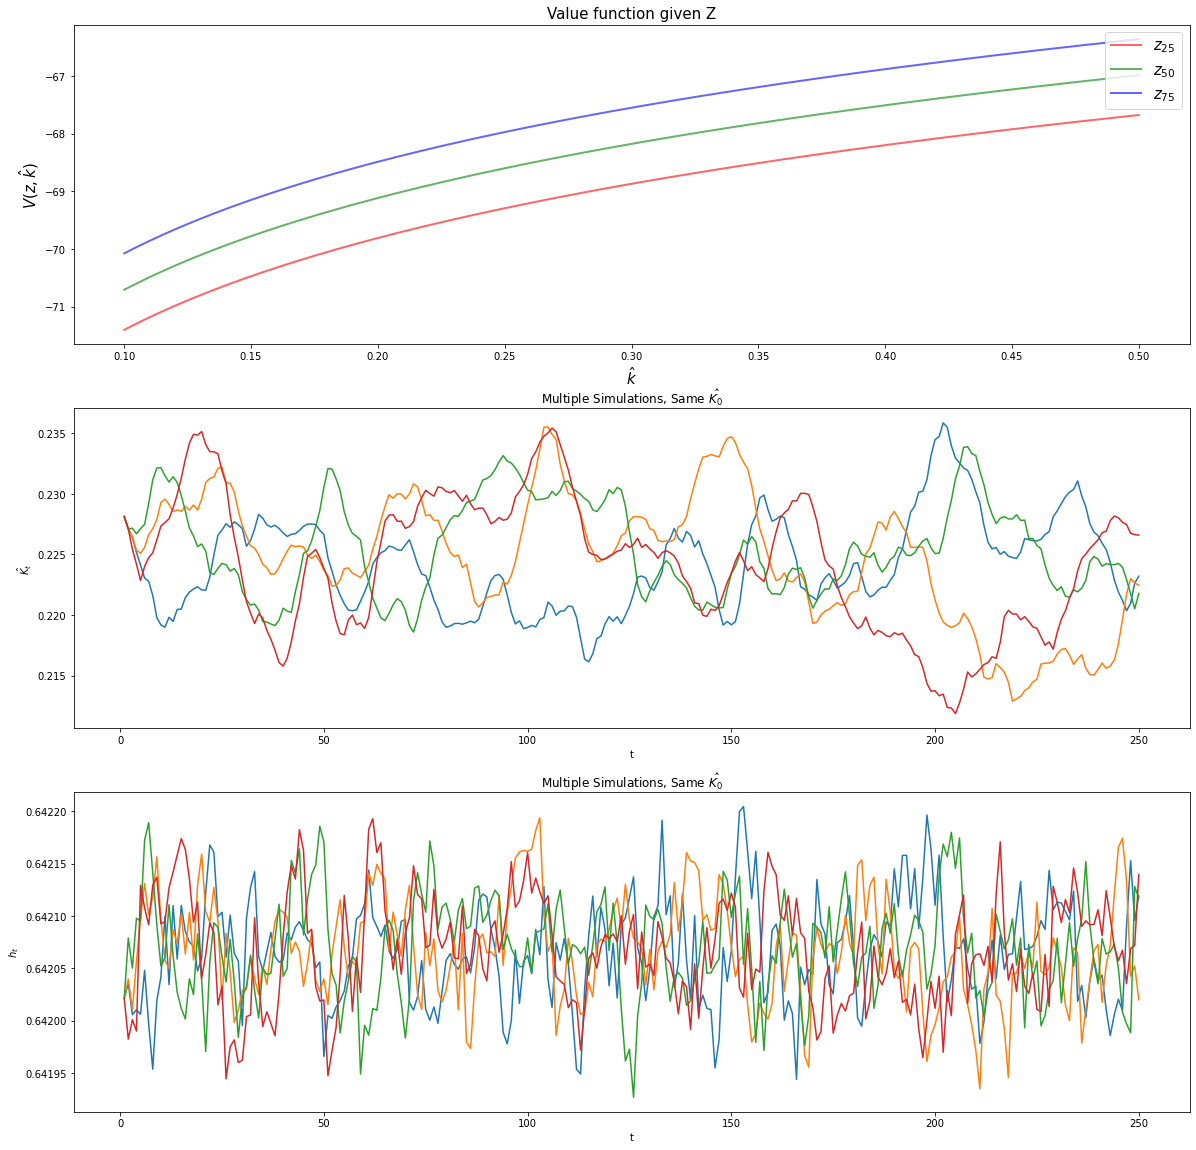

In [204]:
A.plot()

<hr>

### Exercise 2.a ### 

* Note that $(c_t,k_t)$ are detrended. 

* Consumption and Leisure.

We can express the return function in terms of consumption and leisure:

$$U(\hat{c}_t, l_t) = ln\left(\hat{c}_t\right) + \psi ln(l_t) $$

Outline:

Step 1: Do a second order taylor expansion of the return function around $\left(c_{ss}, l_{ss}\right)$.
step 2: Do a first order Taylor expansion of:
$$c_t = e^{\theta ln(k_t)}e^{(1-\theta)ln(z_t)}(1-l_t)^{1-\theta} - \gamma k_{t+1} + (1-\delta) k_t $$
step 3: Obtain a taylor approximation for the production function $y_t=\phi + \phi_k ln(K_t) + \phi_l l_t + \phi_z ln(z_t)$

step 4: Put this result in step 2, and obtain $k_{t+1}$ as a linear function of $\{ln(k_t),c_t,l_t,ln(z_t)\}$

step 5: Rewrite $e ^{ln(k_{t+1})} = \omega + \omega_c c_t + \omega_k ln(k_t)) + \omega_z ln(z_t)$
Notation:
$$u_t=\begin{bmatrix}
c_t\\
l_t\\
\end{bmatrix}$$

$$x_t=\begin{bmatrix}
1\\
ln(k_t)\\
ln(z_{t})
\end{bmatrix}$$


In [75]:
import numpy as np
import sympy
from sympy import *
import matplotlib as plt
import matplotlib.pyplot as plt

class LQ_Method_2_a:

    def __init__(self, ψ, β, θ, δ, ρ, σ, γ_z, γ_n, n_z, n_k, tol, iter, T): 
        self.ψ, self.β, self.θ, self.δ, self.ρ, self.σ, self.γ_z, self.γ_n = ψ, β, θ, δ, ρ, σ, γ_z, γ_n
        #self.γ_hat, self.β_hat = (1+γ_n)*(1+γ_z)**(1-θ), β*(1+γ_n)
        self.γ_hat, self.β_hat = 1.2, 0.75
        self.tol, self.iter = tol, iter        
        self.n_z, self.n_k, self.T = n_z, n_k, T
        self.F_ss()
        self.Derivatives()
        self.Construct_Matrices()
        self.Derivatives_y()
        self.Construct_Matrices_y()
        self.Contraint()
        self.Vaughans_Method()
        self.Ricatti_Iteration()
        self.plot()

    def F_ss(self): #Compute steady state values.
        Λ = (((self.γ_hat/self.β_hat) + self.δ - 1)/self.θ) ** (1/(1-self.θ))
        Θ = ((1-self.θ) * Λ**(-self.θ)) / (Λ**(1-self.θ) + (1 - self.δ - self.γ_hat))
        self.h_ss = (1 + (self.ψ / (Λ * Θ)))**(-1) 
        self.k_ss = (1 - self.h_ss) * (Θ/self.ψ)
        self.y_ss = (self.k_ss)**(self.θ) * (self.h_ss)**(1-self.θ)
        self.c_ss = self.y_ss - self.γ_hat * self.k_ss + (1 - self.δ) * self.k_ss 
        self.l_ss = 1 - self.h_ss
        self.z_ss = 1

    def U(self, c, l):
        return np.log(c) + self.ψ * np.log(l)

    def Derivatives(self): 
        x_ss = np.array([self.c_ss, self.l_ss])
        dim = int(np.shape(x_ss)[0])
        Δ = np.maximum(np.ones([1, dim]) * 10e-8, 10.e-4 * np.abs(x_ss))
        J = np.zeros([dim,1])
        H_aux = np.zeros([dim,np.shape(x_ss)[0]])
        for i in range(dim):
            e_1 = np.zeros([1,dim])
            e_1[0, i] = 1
            y = x_ss + Δ * e_1
            J[i,0] = (self.U(*y[0,:]) - self.U(*x_ss)) / (Δ @ e_1.T)
            for j in range(dim):
                e_2 = np.zeros([1,dim])
                e_2[0, j] = 1
                z_1 = x_ss + Δ * e_1 + Δ * e_2
                H_aux[i,j] = ((self.U(*z_1[0,:]) - self.U(*y[0,:])) / (Δ @ e_1.T) - J[i,0]) / (Δ @ e_2.T)
        self.H = 0.5*H_aux +0.5*H_aux.T
        self.J = J

    def Construct_Matrices(self):
        c, l = symbols('c l')
        x = [c, l]
        x_ss = np.array([self.c_ss, self.l_ss])
        Taylor = self.U(*x_ss) + self.J.T[0,:] @  (x-x_ss) + 0.5 * ((x-x_ss).T @ self.H[:,:] @ (x-x_ss))
        coeff = sympy.expand(Taylor).as_coefficients_dict()
        for k in coeff.keys():
            coeff[k] = float(coeff[k])       
        self.Q = np.array([[coeff[1], 0, 0],\
                           [0, 0, 0],\
                           [0, 0, 0]])
        self.R = np.array([[coeff[c**2], 0.5*coeff[c * l]],\
                           [0.5*coeff[c * l], coeff[l**2]]])
        self.W = 0.5*np.array([[coeff[c], coeff[l]],\
                                [0, 0],\
                                [0, 0]])

    #Get the First order Taylor approximation of the production function.

    def y_t(self, lnk, l, lnz):
        return np.exp(self.θ * lnk) * np.exp( (1-self.θ) * lnz) * (1-l)**(1-self.θ)

    def Derivatives_y(self): 
        x_ss = np.array([ np.log(self.k_ss), self.l_ss, np.log(self.z_ss)])
        dim = int(np.shape(x_ss)[0])
        Δ = np.maximum(np.ones([1, dim]) * 10e-8, 10.e-4 * np.abs(x_ss))
        J_y = np.zeros([np.shape(x_ss)[0],1])
        for i in range(dim):
            e_1 = np.zeros([1,dim])
            e_1[0, i] = 1
            y = x_ss + Δ * e_1
            J_y[i,0] = (self.y_t(*y[0,:]) - self.y_t(*x_ss)) / (Δ @ e_1.T)
        self.J_y = J_y

    #This function approximates the production function with a First order taylor expansion.

    def Construct_Matrices_y(self): 
        ln_k, l, ln_z = symbols('ln_k l ln_z')
        x = [ln_k, l, ln_z]
        x_ss = np.array([np.log(self.k_ss), self.l_ss, np.log(self.z_ss)])
        Taylor_y = self.y_t(*x_ss) + self.J_y.T[0,:] @ (x-x_ss)
        coeff_y = sympy.expand(Taylor_y).as_coefficients_dict()
        for k in coeff_y.keys():
            coeff_y[k] = float(coeff_y[k])
        self.coeff_y = coeff_y
                   
    def Contraint(self):
        lnk_p, ln_k, c, l, ln_z = symbols('lnk_p ln_k c l ln_z')
        x_ss = np.array([np.log(self.k_ss), np.log(self.k_ss), self.c_ss, self.l_ss, np.log(self.z_ss)])
        Aux = (self.coeff_y[1] + self.coeff_y[ln_k] * ln_k + self.coeff_y[l] * l + self.coeff_y[ln_z] * ln_z) +\
                        (1-self.δ) * (np.exp(x_ss[0]) + np.exp(x_ss[0]) * (ln_k - x_ss[0])) \
                            - (self.γ_hat) * (np.exp(x_ss[1]) + np.exp(x_ss[1]) * (lnk_p - x_ss[1]) ) - c 
        coeff_aux = sympy.expand(Aux).as_coefficients_dict()
        for k in coeff_aux.keys():
            coeff_aux[k] = float(coeff_aux[k])
        Aux_Dic = sympy.expand((-1/coeff_aux[lnk_p]) * (Aux - coeff_aux[lnk_p] * lnk_p)).as_coefficients_dict()
        for k in Aux_Dic.keys():
            Aux_Dic[k] = float(Aux_Dic[k])
        self.A = np.array([[1, 0, 0],\
                            [Aux_Dic[1], Aux_Dic[ln_k], Aux_Dic[ln_z]],\
                            [0, 0, self.ρ]])
        self.B = np.array([[0, 0],\
                            [Aux_Dic[c],Aux_Dic[l]],
                            [0, 0]])

        self.A_bar = np.sqrt(self.β_hat) * (self.A - (self.B @ np.linalg.inv(self.R) @ self.W.T))
        self.B_bar = np.sqrt(self.β_hat) * self.B
        self.Q_bar = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def Ricatti_Iteration(self):
        iter = int(1)
        P_0 = np.ones([3,3])
        P_1 = np.ones([3,3])
        while iter < self.iter:
            iter +=1
            P_1 = self.Q_bar + self.A_bar.T @ P_0 @ self.A_bar - self.A_bar.T @ P_0 @ self.B_bar @ np.linalg.inv( self.R + self.B_bar.T @ P_0 @ self.B_bar) @ self.B_bar.T @ P_0 @ self.A_bar
            if self.error(P_0, P_1)<self.tol:
                print('Solution Found')
                self.P_Ricatti = P_1
                self.F_Ricatti = np.linalg.inv(self.R + self.B_bar.T @ self.P_Ricatti @ self.B_bar)  @ (self.B_bar.T @ self.P_Ricatti @ self.A_bar) + np.linalg.inv(self.R) @ self.W.T
                break
            else:
                P_0 = P_1.copy()

    def error(self, V1, V2):
        return np.nanmax(np.abs(V1-V2))

    def V(self,X,P):
        return X.T @ P @ X

    def Vaughans_Method(self):
        H11 = np.linalg.inv(self.A_bar)
        H12 = np.linalg.inv(self.A_bar) @ self.B_bar @ np.linalg.inv(self.R) @ self.B_bar.T
        H21 = self.Q_bar @ np.linalg.inv(self.A_bar)
        H22 =  self.Q_bar @ np.linalg.inv( self.A_bar) @  self.B_bar @ np.linalg.inv(self.R) @ self.B_bar.T + self.A_bar.T
        HAM = np.concatenate((np.concatenate((H11,H12),1),np.concatenate((H21,H22),1)),0)
        λ, v = np.linalg.eig(HAM)
        index = np.where(np.sqrt(λ.real**2 + λ.imag**2)>1, 1, 0)
        Λ = np.diag(λ[(index)==True])
        V = np.empty([shape(HAM)[0],shape(HAM)[0]])
        aux_1 = 0
        aux_2 = 0 
        for i in range(shape(HAM)[0]):
            if index[i] == 1:
                V[:, aux_1] = v[:, i]
                aux_1 += 1 
            if index[i] == 0:
                V[:, -1-aux_2] = v[:, i]
                aux_2 += 1
        V_11 = V[0:3, 0:3]
        V_21 = V[3:6, 0:3]
        V_12 = V[0:3, 3:6]
        V_22 = V[3:6, 3:6]
        self.P_Vaughans = V_21 @ np.linalg.inv(V_11)
        self.F_Vaughans= np.linalg.inv(self.R + self.B_bar.T @ self.P_Vaughans @ self.B_bar) @ (self.B_bar.T @ self.P_Vaughans @ self.A_bar) + np.linalg.inv(self.R) @ self.W.T 

    def plot(self):
        Z = np.random.normal(0, self.σ, self.T) 
        X = np.array([[1], [np.log(self.k_ss)], [np.log(self.z_ss)]])
        for z in Z:
            k_prime = np.exp(self.θ * X[1, -1]) * np.exp((1-self.θ) * X[2, -1]) * (1 + (self.F_Vaughans @ X[:,-1])[1] )**(1-self.θ) + (1-self.δ) * np.exp(X[1,-1]) + (self.F_Vaughans @ X[:,-1])[0]
            X_prime = np.array([[1],[np.log(k_prime)], [self.ρ * X[2, -1] + z]])
            X = np.concatenate((X, X_prime), axis=1)
        self.X = X 
        self.H = -self.F_Vaughans[1,:] @ X               

In [76]:
A = LQ_Method_2_Data = [
    ('ψ', np.float64),      
    ('β', np.float64),      
    ('θ', np.float64),
    ('δ', np.float64),
    ('ρ', np.float64),
    ('σ', np.float64),
    ('γ_z', np.float64),
    ('γ_n', np.float64),
    ('n_z', np.integer), 
    ('n_k', np.integer),
    ('tol', np.float64), 
    ('iter', np.integer),
    ('T', np.integer)]

A = LQ_Method_2_a(ψ = 0.3, β=0.95, θ=0.4, δ=0.6, ρ=0.9, σ=0, γ_z=0.01, γ_n=0.01, n_z=25, n_k=100, T=250, tol=10e-4, iter=3000)

Solution Found


In [77]:
A.P_Ricatti

array([[-5.66971793,  0.25483081,  0.88121937],
       [ 0.25483081, -0.05090784, -0.17604218],
       [ 0.88121937, -0.17604218, -0.60876383]])

In [80]:
1-A.H, 1-A.l_ss

(array([0.73198131, 0.72503794, 0.71830683, 0.71209722, 0.70658932,
        0.70184831, 0.69785802, 0.69455483, 0.69185362, 0.6896645 ,
        0.68790217, 0.68649046, 0.68536383, 0.68446723, 0.68375524,
        0.68319077, 0.68274382, 0.68239027, 0.68211081, 0.68189005,
        0.68171574, 0.68157815, 0.68146959, 0.68138393, 0.68131637,
        0.68126309, 0.68122107, 0.68118794, 0.68116182, 0.68114122,
        0.68112498, 0.68111218, 0.68110209, 0.68109413, 0.68108786,
        0.68108292, 0.68107902, 0.68107595, 0.68107352, 0.68107161,
        0.68107011, 0.68106892, 0.68106799, 0.68106725, 0.68106667,
        0.68106621, 0.68106585, 0.68106557, 0.68106534, 0.68106516,
        0.68106503, 0.68106492, 0.68106483, 0.68106476, 0.68106471,
        0.68106466, 0.68106463, 0.6810646 , 0.68106458, 0.68106457,
        0.68106455, 0.68106454, 0.68106454, 0.68106453, 0.68106452,
        0.68106452, 0.68106452, 0.68106452, 0.68106451, 0.68106451,
        0.68106451, 0.68106451, 0.68106451, 0.68

<hr/>

Exercise 2.c Capital today and capital tomorrow

From the FOC of the agent:




* Note that $(c_t,k_t)$ are detrended. 


We can express the return function in terms of consumption and leisure:

$$U(\hat{c}_t, l_t) = ln\left(\hat{c}_t\right) + \psi ln(l_t) $$

Outline:

Step 1: Do a second order taylor expansion of the return function around $\left(lnk_{ss}, l_{ss}\right)$.
step 2: Do a first order Taylor expansion of:
$$c_t = e^{\theta ln(k_t)}e^{(1-\theta)ln(z_t)}(1-l_t)^{1-\theta} - \gamma k_{t+1} + (1-\delta) k_t $$
step 3: Obtain a taylor approximation for the production function $y_t=\phi + \phi_k ln(K_t) + \phi_l l_t + \phi_z ln(z_t)$
step 4: Put this result in step 2, and obtain $k_{t+1}$ as a linear function of $\{ln(k_t),c_t,l_t,ln(z_t)\}$

step 5: Rewrite $e ^{ln(k_{t+1})} = \omega + \omega_c c_t + \omega_k ln(k_t)) + \omega_z ln(z_t)$
Notation:
$$u_t=\begin{bmatrix}
ln(k_{t+1})\\
\end{bmatrix}$$

$$x_t=\begin{bmatrix}
1\\
ln(k_t)\\
ln(z_{t})
\end{bmatrix}$$


In [20]:
import scipy.optimize
import numba
import numpy as np
import sympy
from sympy import *
import matplotlib as plt
import matplotlib.pyplot as plt
from numba import njit

In [21]:
β = 0.75 # choose in (0,1)
ρ = 0.9 # autocorrelation across periods
σ = 0.2 # standard deviation of epsilon
θ = 0.4
γ = 1.2 # gamma >= 1
ψ = 0.3 
δ = 0.6 # choose in (0,1]

In [22]:
Λ = (((γ/β) + δ - 1)/θ) ** (1/(1-θ))
Θ = ((1-θ) * Λ**(-θ)) / (Λ**(1-θ) + (1 -δ - γ))
h_ss = (1 + (ψ / (Λ * Θ)))**(-1) 
k_ss = (1 - h_ss) * (Θ/ψ)
y_ss = (k_ss)**(θ) * (h_ss)**(1-θ)
c_ss = y_ss - γ * k_ss + (1 - δ) * k_ss 
l_ss = 1 - h_ss
z_ss = 1

In [32]:
def h(lnk, lnkp, lnz):
    def h_optimal(h):
        k = np.exp(lnk)
        kp = np.exp(lnkp)
        z = np.exp(lnz)
        x = ψ * (k**(θ)* (z*h)**(1-θ) - γ * kp + (1-δ) * k) / (1 - h) - (1-θ) * (k**(θ)*(z)**(1-θ)*h**(-θ))
        return x
    return scipy.optimize.fsolve(h_optimal, 0.5)[0]

In [31]:
h(np.log(0.5),np.log(0.5),0)

0.8299620998609297

In [42]:
def U(lnk, lnkp, lnz):
    k = np.exp(lnk)
    kp = np.exp(lnkp)
    z = np.exp(lnz)
    return np.log(k**(θ) * (z*h(lnk, lnkp, lnz))**(1-θ) - γ * kp + (1-δ) * k) + ψ * np.log( 1 - h(lnk, lnkp, lnz))

In [44]:
x_ss = np.array([np.log(k_ss), np.log(k_ss), np.log(z_ss)])
dim = int(np.shape(x_ss)[0])
Δ = np.maximum(np.ones([1, dim]) * 10e-8, 10.e-4 * np.abs(x_ss))
J = np.zeros([dim,1])
H_aux = np.zeros([dim,np.shape(x_ss)[0]])
for i in range(dim):
    e_1 = np.zeros([1,dim])
    e_1[0, i] = 1
    y = x_ss + Δ * e_1
    J[i,0] = (U(*y[0,:]) - U(*x_ss)) / (Δ @ e_1.T)
    for j in range(dim):
        e_2 = np.zeros([1,dim])
        e_2[0, j] = 1
        z_1 = x_ss + Δ * e_1 + Δ * e_2
        H_aux[i,j] = ((U(*z_1[0,:]) - U(*y[0,:])) / (Δ @ e_1.T) - J[i,0]) / (Δ @ e_2.T)
H = 0.5*H_aux +0.5*H_aux.T

In [51]:
lnk, lnkp, lnz = symbols('lnk lnkp lnz')
x = [lnk, lnkp, lnz]
Taylor = U(*x_ss) + J.T[0,:] @  (x-x_ss) + 0.5 * ((x-x_ss).T @ H[:,:] @ (x-x_ss))
coeff = sympy.expand(Taylor).as_coefficients_dict()
for k in coeff.keys():
    coeff[k] = float(coeff[k]) 

In [62]:
      
Q = np.array([[coeff[1], 0.5*coeff[lnk], 0.5*coeff[lnz]],\
              [0.5*coeff[lnk], coeff[lnk**2], 0.5*coeff[lnk*lnz]],\
              [0.5*coeff[lnz], 0.5*coeff[lnk*lnz], coeff[lnz**2]]])

W = 0.5 * np.array([[coeff[lnkp]],\
                    [coeff[lnkp*lnk]],\
                    [coeff[lnkp*lnz]]])

R = np.array([[coeff[lnkp**2]]])

A = np.array([[1, 0, 0], [0, 0, 0], [0, 0, ρ]])

B = np.array([[0],
              [1],
              [0]])


In [63]:
A_bar = np.sqrt(β) * (A - (B  @ W.T * R**-1))
B_bar = np.sqrt(β) * B
Q_bar = Q - (W @ W.T * R**-1)

In [67]:
def error( V1, V2):
    return np.nanmax(np.abs(V1-V2))

def V(X,P):
    return X.T @ P @ X
 
iter = int(1)
P_0 = np.zeros([3,3])
P_1 = np.ones([3,3])
while iter < 1000:
    iter +=1
    P_1 = Q_bar + A_bar.T @ P_0 @ A_bar - A_bar.T @ P_0 @ B_bar @ np.linalg.inv( R +B_bar.T @ P_0 @ B_bar) @ B_bar.T @ P_0 @ A_bar
    if error(P_0, P_1)< 10e-6:
        print('Solution Found')
        P_Ricatti = P_1
        F_Ricatti = np.linalg.inv(R + B_bar.T @ P_Ricatti @ B_bar)  @ (B_bar.T @ P_Ricatti @ A_bar) + np.linalg.inv(R) @ W.T
        break
    else:
        P_0 = P_1.copy()

Solution Found


In [74]:
H11 = np.linalg.inv(A_bar)
H12 = np.linalg.inv(A_bar) @ B_bar @ np.linalg.inv(R) @ B_bar.T
H21 = Q_bar @ np.linalg.inv(A_bar)
H22 =  Q_bar @ np.linalg.inv( A_bar) @  B_bar @ np.linalg.inv(R) @ B_bar.T + A_bar.T
HAM = np.concatenate((np.concatenate((H11,H12),1),np.concatenate((H21,H22),1)),0)
λ, v = np.linalg.eig(HAM)
index = np.where(np.sqrt(λ.real**2 + λ.imag**2)>1, 1, 0)
Λ = np.diag(λ[(index)==True])
V = np.empty([shape(HAM)[0],shape(HAM)[0]])
aux_1 = 0
aux_2 = 0 
for i in range(shape(HAM)[0]):
    if index[i] == 1:
        V[:, aux_1] = v[:, i]
        aux_1 += 1 
    if index[i] == 0:
        V[:, -1-aux_2] = v[:, i]
        aux_2 += 1
V_11 = V[0:3, 0:3]
V_21 = V[3:6, 0:3]
V_12 = V[0:3, 3:6]
V_22 = V[3:6, 3:6]
P_Vaughans = V_21 @ np.linalg.inv(V_11)
F_Vaughans= np.linalg.inv(R + B_bar.T @ P_Vaughans @ B_bar) @ (B_bar.T @ P_Vaughans @ A_bar) + np.linalg.inv(R) @ W.T

In [73]:
P_Vaughans, P_Ricatti

(array([[-5.27865701,  0.43920031,  1.18570812],
        [ 0.43920031,  0.0354493 , -0.03353107],
        [ 1.18570812, -0.03353107,  0.10641093]]),
 array([[-5.27863377,  0.43920031,  1.18570807],
        [ 0.43920031,  0.0354493 , -0.03353107],
        [ 1.18570807, -0.03353107,  0.10641093]]))

In [81]:
k_ss

0.11725606262661863

In [80]:
X = np.array([[1], [np.log(k_ss)], [np.log(z_ss)]])
np.exp(- F_Ricatti @ X)      

array([[0.11702133]])

In [89]:
def Policy(lnk, lnz):
    return np.exp(-(F_Ricatti @ np.array([1, lnk, lnz]))[0])
        

In [114]:
T = 100
σ = 0.01
Policy_k = np.zeros((1,T))
shocks = np.random.normal(0, σ, T)
lnz = np.zeros((1,T))
for i in range(T):
    if i==0:
        lnz[0,i] = np.log(z_ss)
    else:
        lnz[0,i] = ρ * lnz[0,i-1] + shocks[i]

for i in range(T):
    if i==0:
        Policy_k[i,i] = Policy(np.log(k_ss), np.log(z_ss))
    else:
        Policy_k[0,i] = Policy(np.log(Policy_k[0,i-1]), lnz[0,i])

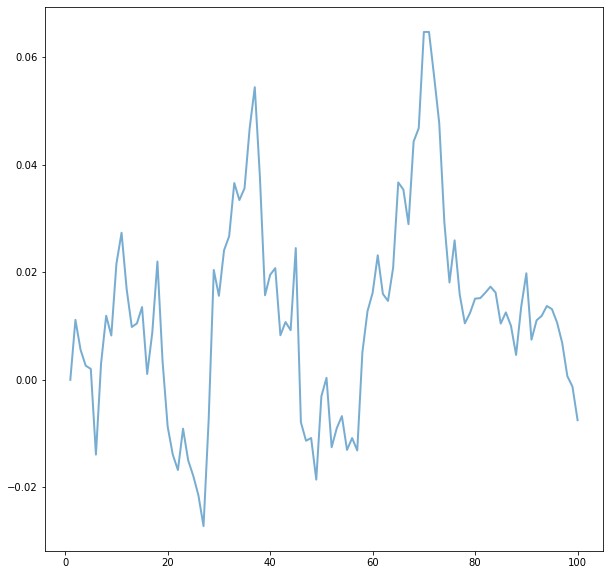

In [126]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.linspace(1, T, shape(lnz[0,:])[0]), lnz[0,:], linewidth=2, alpha=0.6)
plt.show()

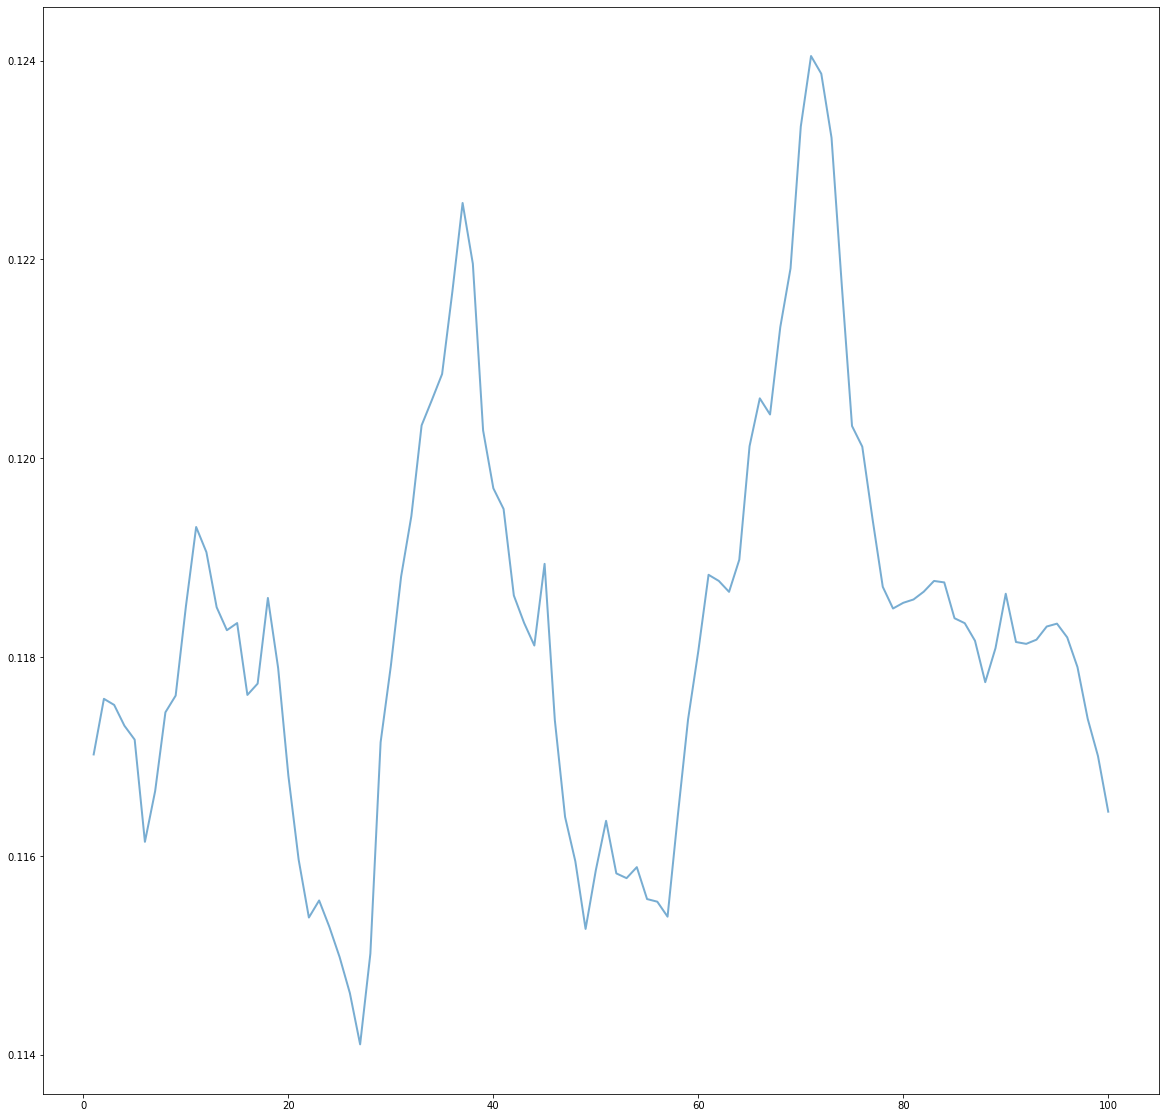

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.linspace(1, T, shape(lnz[0,:])[0]), Policy_k[0,:], linewidth=2, alpha=0.6)
plt.show()

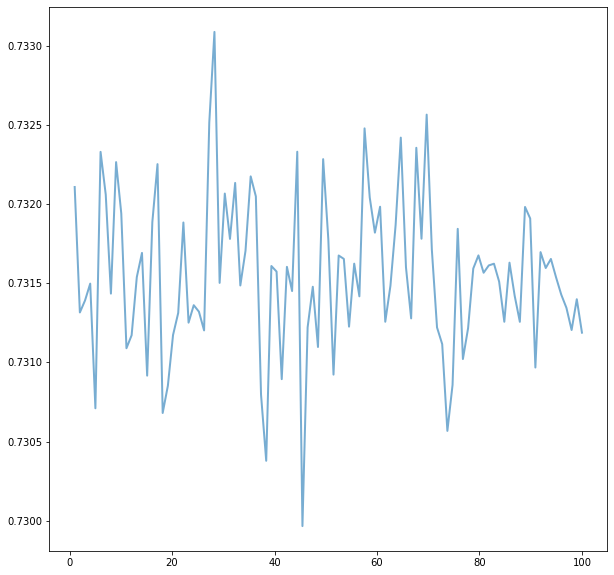

In [125]:
h = np.vectorize(h)
fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(np.linspace(1, T, shape(lnz[0,:])[0]-1), h(np.log(Policy_k[0,:-1]), np.log(Policy_k[0,1:]), lnz[0,0:-1]), linewidth=2, alpha=0.6)
plt.show()

In [116]:
Policy_k[0,:], lnz[0,:], np.linspace(1, shape(lnz[0,:])[0])

(array([0.11702133, 0.1175806 , 0.11751921, 0.11731014, 0.11717002,
        0.11614212, 0.11665358, 0.11744488, 0.11761308, 0.11851034,
        0.11930886, 0.11905564, 0.11850182, 0.1182708 , 0.11834271,
        0.11761978, 0.11773368, 0.11859506, 0.11789058, 0.11680614,
        0.11596393, 0.11538099, 0.11555259, 0.11528657, 0.11498291,
        0.1146208 , 0.11410516, 0.11501764, 0.11714401, 0.1179131 ,
        0.11881082, 0.11941847, 0.12033106, 0.12058554, 0.12084741,
        0.12167464, 0.12256772, 0.12195609, 0.12028041, 0.11969832,
        0.11948985, 0.11862003, 0.1183444 , 0.11811673, 0.11893823,
        0.1173663 , 0.11639268, 0.11594659, 0.11526615, 0.11585674,
        0.11635378, 0.1158249 , 0.11577696, 0.11588779, 0.11556674,
        0.11554022, 0.11538958, 0.11640576, 0.11737337, 0.1180603 ,
        0.11882813, 0.11876653, 0.11865657, 0.11898003, 0.12012076,
        0.12060287, 0.12044034, 0.12131926, 0.12191013, 0.1233364 ,
        0.12404576, 0.12386753, 0.12322357, 0.12

<hr>

Exercise 3:


RE-use the code for exercise 1.b.b

In [79]:
import numpy as np
import sympy
from sympy import *
import matplotlib as plt
import matplotlib.pyplot as plt

class Exercise_3:

    def __init__(self, ψ, σ_u, β, θ, δ, ρ, σ, γ_z, γ_n, n_z, n_k, tol, iter, T): #Unload parameters:
        self.ψ, self.β, self.θ, self.δ, self.ρ, self.σ, self.γ_z, self.γ_n, self.σ_u = ψ, β, θ, δ, ρ, σ, γ_z, γ_n, σ_u
        self.γ_hat, self.β_hat = (1+γ_n)*(1+γ_z)**(1-θ), β*(1+γ_n)
        self.tol, self.iter = tol, iter        
        self.n_z, self.n_k, self.T = n_z, n_k, T
        self.F_ss()
        self.Derivatives()
        self.Construct_Matrices()
        self.Vaughans_Method()
        self.Ricatti_Iteration()
        self.plot()

    def F_ss(self): #Compute steady state values.
        Λ = (((self.γ_hat/self.β_hat) + self.δ - 1)/self.θ) ** (1/(1-self.θ))
        Θ = ((1-self.θ) * Λ**(-self.θ)) / (Λ**(1-self.θ) + (1 - self.δ - self.γ_hat))
        self.h_ss = (1 + (self.ψ / (Λ * Θ)))**(-1) 
        self.k_ss = (1 - self.h_ss) * (Θ/self.ψ)
        self.y_ss = (self.k_ss)**(self.θ) * (self.h_ss)**(1-self.θ)
        self.c_ss = self.y_ss - (self.γ_hat + 1 - self.δ) * self.k_ss
        self.l_ss = 1 - self.h_ss
        self.z_ss = 1

    def U(self, ln_k, ln_k_p, h, ln_z):
        c = np.exp(self.θ * ln_k + (1-self.θ) * (ln_z)) * h**(1-self.θ) - self.γ_hat * np.exp(ln_k_p) + \
                    (1-self.δ) * np.exp(ln_k)
        l = 1 - h
        if c>= 0 and 1>=l>=0:
            return (c * l**(self.ψ))**(1-self.σ_u) / (1-self.σ_u)
        else: 
            return -np.inf

    def Derivatives(self): #Given the utility function compute Jacobian and Hessian matrix.
        x_ss = np.array([np.log(self.k_ss), np.log(self.k_ss), self.h_ss, np.log(self.z_ss)])
        dim = int(np.shape(x_ss)[0])
        Δ = np.maximum(np.ones([1, dim]) * 10e-8, 10.e-4 * np.abs(x_ss))
        J = np.zeros([4,1])
        H_aux = np.zeros([4,4])
        for i in range(dim):
            e_1 = np.zeros([1,dim])
            e_1[0, i] = 1
            y = x_ss + Δ * e_1
            J[i,0] = (self.U(*y[0,:]) - self.U(*x_ss)) / (Δ @ e_1.T)
            for j in range(dim):
                e_2 = np.zeros([1,dim])
                e_2[0, j] = 1
                z_1 = x_ss + Δ * e_1 + Δ * e_2
                H_aux[i,j] = ((self.U(*z_1[0,:]) - self.U(*y[0,:])) / (Δ @ e_1.T) - J[i,0]) / (Δ @ e_2.T)
        self.H = 0.5*H_aux +0.5*H_aux.T
        self.J = J

    def Construct_Matrices(self):
        ln_k, ln_k_p, h, ln_z = symbols('ln_k ln_k_p h ln_z')
        x = [ln_k, ln_k_p, h, ln_z]
        x_ss = np.array([np.log(self.k_ss), np.log(self.k_ss), self.h_ss, np.log(self.z_ss)])
        Taylor = self.U(*x_ss) + self.J.T[0,:] @  (x-x_ss) + 0.5 * ((x-x_ss).T @ self.H[:,:] @ (x-x_ss))
        coeff = sympy.expand(Taylor).as_coefficients_dict()
        for k in coeff.keys():
            coeff[k] = float(coeff[k])
                   
        self.Q = np.array([[coeff[1], 0.5*coeff[ln_k], 0.5*coeff[ln_z]],\
                           [0.5*coeff[ln_k], coeff[ln_k**2], 0.5*coeff[ln_k*ln_z]],\
                           [0.5*coeff[ln_z], 0.5*coeff[ln_k*ln_z], coeff[ln_z**2]]])
        self.R = np.array([[coeff[ln_k_p**2], 0.5*coeff[ln_k_p * h]],\
                           [0.5*coeff[ln_k_p * h], coeff[h**2]]])
        self.W = 0.5*np.array([[coeff[ln_k_p], coeff[h]],\
                           [coeff[ln_k*ln_k_p], coeff[ln_k*h]],\
                           [coeff[ln_z*ln_k_p], coeff[ln_z*h]]])
        self.A = np.array([[1, 0, 0], [0, 0, 0], [0, 0, self.ρ]])
        self.B = np.array([[0, 0],[1, 0],[0, 0]])
        self.A_bar = np.sqrt(self.β_hat) * (self.A - (self.B @ np.linalg.inv(self.R) @ self.W.T))
        self.B_bar = np.sqrt(self.β_hat) * self.B
        self.Q_bar = self.Q - (self.W @ np.linalg.inv(self.R) @ self.W.T)

    def Ricatti_Iteration(self):
        iter = int(1)
        P_0 = np.zeros([3,3])
        P_1 = np.ones([3,3])
        while iter < self.iter:
            iter +=1
            P_1 = self.Q_bar + self.A_bar.T @ P_0 @ self.A_bar - self.A_bar.T @ P_0 @ self.B_bar @ np.linalg.inv( self.R + self.B_bar.T @ P_0 @ self.B_bar) @ self.B_bar.T @ P_0 @ self.A_bar
            if self.error(P_0, P_1)<self.tol:
                print('Solution Found')
                self.P_Ricatti = P_1
                self.F_Ricatti = np.linalg.inv(self.R + self.B_bar.T @ self.P_Ricatti @ self.B_bar)  @ (self.B_bar.T @ self.P_Ricatti @ self.A_bar) + np.linalg.inv(self.R) @ self.W.T
                break
            else:
                P_0 = P_1.copy()
    
    def error(self, V1, V2):
        return np.nanmax(np.abs(V1-V2))

    def V(self,X,P):
        return X.T @ P @ X

    def Vaughans_Method(self):
        H11 = np.linalg.inv(self.A_bar)
        H12 = np.linalg.inv(self.A_bar) @ self.B_bar @ np.linalg.inv(self.R) @ self.B_bar.T
        H21 = self.Q_bar @ np.linalg.inv(self.A_bar)
        H22 =  self.Q_bar @ np.linalg.inv( self.A_bar) @  self.B_bar @ np.linalg.inv(self.R) @ self.B_bar.T + self.A_bar.T
        HAM = np.concatenate((np.concatenate((H11,H12),1),np.concatenate((H21,H22),1)),0)
        λ, v = np.linalg.eig(HAM)
        index = np.where(np.sqrt(λ.real**2 + λ.imag**2)>1, 1, 0)
        Λ = np.diag(λ[(index)==True])
        V = np.empty([shape(HAM)[0],shape(HAM)[0]])
        aux_1 = 0
        aux_2 = 0 
        for i in range(shape(HAM)[0]):
            if index[i] == 1:
                V[:, aux_1] = v[:, i]
                aux_1 += 1 
            if index[i] == 0:
                V[:, -1-aux_2] = v[:, i]
                aux_2 += 1
        V_11 = V[0:3, 0:3]
        V_21 = V[3:6, 0:3]
        V_12 = V[0:3, 3:6]
        V_22 = V[3:6, 3:6]
        self.P_Vaughans = V_21 @ np.linalg.inv(V_11)
        self.F_Vaughans= np.linalg.inv(self.R + self.B_bar.T @ self.P_Vaughans @ self.B_bar) @ (self.B_bar.T @ self.P_Vaughans @ self.A_bar) + np.linalg.inv(self.R) @ self.W.T
 
    def plot(self):
        fig, ax = plt.subplots(3, figsize=(20, 20))
        #Value functions:
        labels = [r'$z_{25}$', r'$z_{50}$', r'$z_{75}$']
        aux = [0.25, 0.50, 0.75]
        colors = ['r-' ,'g-' , 'b-']
        for i in range(3):
            z = [0.90, 1, 1.10]
            X_1 = np.ones((1,self.T))
            X_2 = np.log(np.linspace(0.1, 0.5, self.T)).reshape(1,self.T)
            X_3 = np.log(z[i]) * np.ones((1,self.T))
            X = np.concatenate((np.concatenate((X_1, X_2), axis=0), X_3), axis=0) 
            ax[0].plot(np.linspace(0.1, 0.5, self.T), np.diagonal(self.V(X, self.P_Ricatti)), colors[i], linewidth=2, label= labels[i], alpha=0.6)
        ax[0].set_title("Value function given Z", fontsize = 15)
        ax[0].set_xlabel(r'$\hat{k}$', fontsize = 15)
        ax[0].set_ylabel(r'$V(z,\hat{k})$',fontsize = 15)
        ax[0].legend(loc="upper right", fontsize = 15)
        # Capital and leisure Simulation:
        for j in range(4):
            T=250
            k = np.zeros((1,self.T)) 
            h = np.zeros((1,self.T)) 
            X_0 = np.array([[1],[np.log(self.k_ss)],[np.log(self.z_ss)]])
            for i in range(self.T):
                X = X_0.copy()    
                U = - self.F_Ricatti @ X
                k[0,i] = np.exp(X[1, 0])
                h[0,i] = U[1,0].copy()
                X_0 = np.array([[1],[U[0,0]],[self.ρ * X[2,0] + np.random.normal(0, self.σ)]]) #Update X
                X = X_0.copy()
            ax[1].plot(np.linspace(1,self.T,self.T), k[0,:]) 
            ax[2].plot(np.linspace(1,self.T,self.T), h[0,:])  
        ax[1].set_xlabel("t")
        ax[1].set_ylabel(r'$\hat{K_t}$')  
        ax[1].set_title("Multiple Simulations, Same " r'$\hat{K_0}$')
        ax[2].set_xlabel("t")
        ax[2].set_ylabel(r'${h_t}$')  
        ax[2].set_title("Multiple Simulations, Same " r'$\hat{K_0}$')

Solution Found


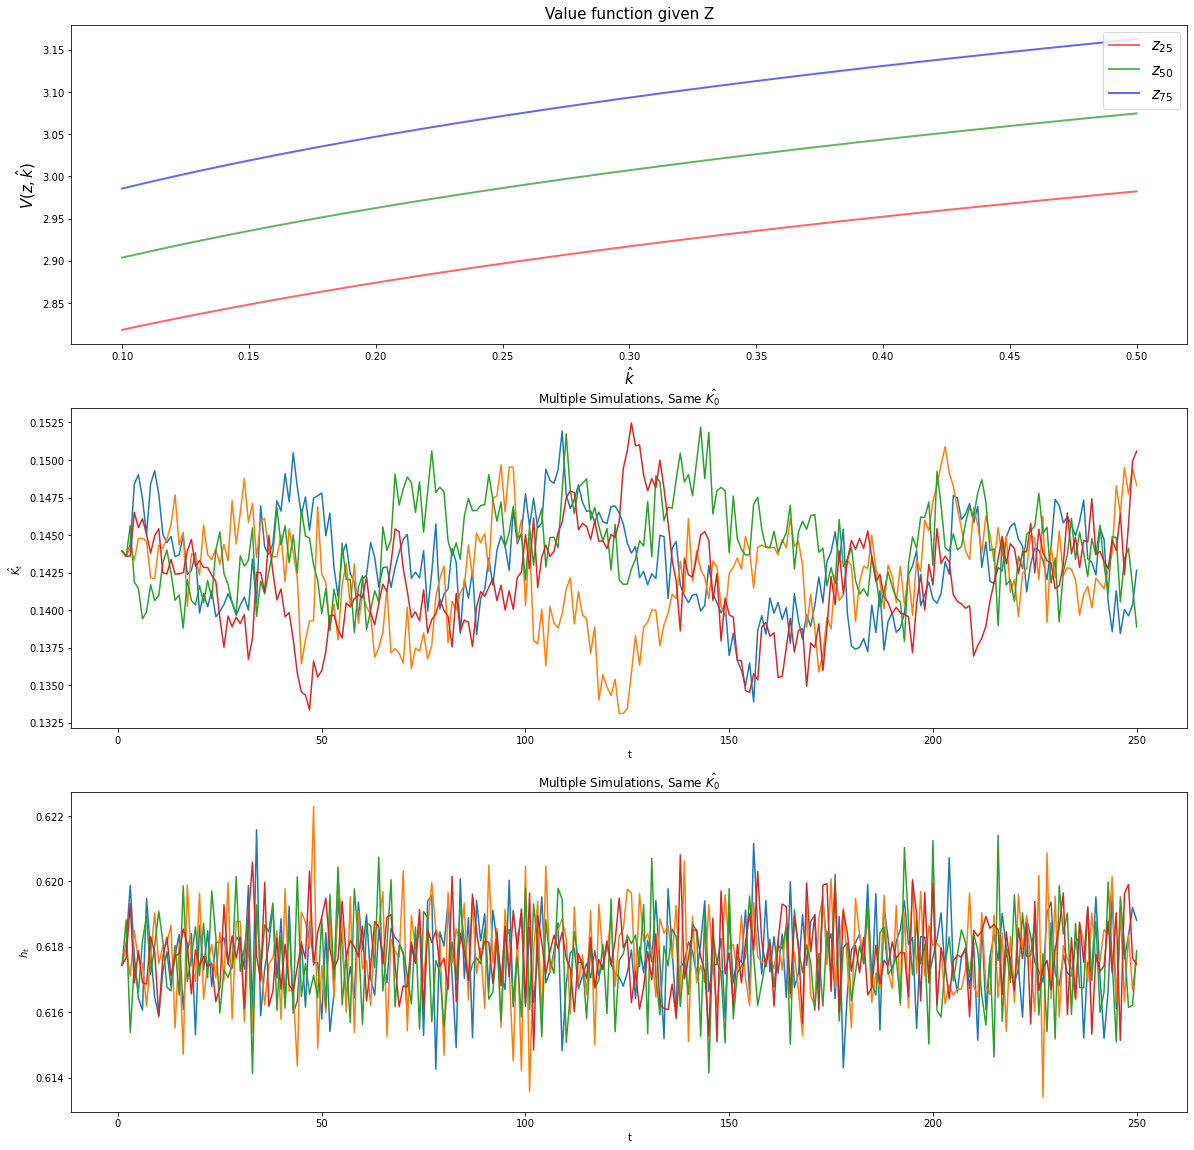

In [80]:
LQ_Method_3_Data = [
    ('ψ', np.float64),      
    ('β', np.float64),      
    ('θ', np.float64),
    ('δ', np.float64),
    ('ρ', np.float64),
    ('σ', np.float64),
    ('γ_z', np.float64),
    ('γ_n', np.float64),
    ('n_z', np.integer), 
    ('n_k', np.integer),
    ('tol', np.float64), 
    ('iter', np.integer),
    ('T', np. integer)]

A = Exercise_3(ψ = 0.6, σ_u = 0, β=0.95, θ=0.4, δ=0.9, ρ=0.9, σ=0.01, γ_z=0.01, γ_n=0.01, n_z=25, n_k=100, T=250, tol=10e-4, iter=3000)
#B = Exercise_3(ψ = 0.5, σ_u = 5, β=0.95, θ=0.7, δ=0.9, ρ=0.9, σ=0.01, γ_z=0.01, γ_n=0.01, n_z=25, n_k=100, T=250, tol=10e-4, iter=3000)